In [ ]:
#!pip3 install tensorflow==2.3.0
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

from tensorflow.keras.layers import Input, InputLayer, Dense, Flatten, Conv2D,Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import MaxPooling2D
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import  Model
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, cv2
import random
import pywt
import scipy
from tensorflow import keras
np.random.seed(0) #Don't change this line. In each notebook, the seed is set to 0. So that same random orders are generated.

2.3.0
2.4.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path='/content/drive/MyDrive/Colab_Dataset/org_brain_canc_data/original_data/data/train'
list_folder=os.listdir(path = data_path)
data=[]
im_size=121  
for i in list_folder:
    new_path=os.path.join(data_path,i) 
    pic_list=os.listdir(new_path)                                               
    for img in pic_list:
        pic=os.path.join(new_path,img)   
        arr=cv2.imread(pic,0)
        cA, _ = pywt.dwt2(arr,'db2')    #Performing DWT operation
        data.append([cA,list_folder.index(i)])    
        
random.Random(0).shuffle(data)  #Don't change this line. In each notebook, the seed is set to 0. So that same random orders are generated.
x_train,y_train=[],[]
for i,j in data:
    x_train.append(cv2.resize(i,(121,121)))
    y_train.append(j)
x_train=np.array(x_train).reshape(-1,im_size,im_size,1)
y_train=np.array(y_train).reshape(-1,1)

encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train)
x_train = x_train/255
y_train = y_train.toarray()


X_train, X_test, Y_train, Y_test = train_test_split(x_train,y_train, test_size=0.20,random_state=0) #Don't change this line. In each notebook, the seed is set to 0. So that same random orders are generated.


print('Dimensions of images:',X_train.shape[1:])
print('Number of images in training set :',X_train.shape[0])
print('Number of images in testing set :',X_test.shape[0])

Dimensions of images: (121, 121, 1)
Number of images in training set : 769
Number of images in testing set : 193


In [ ]:
train_labels = np.argmax(Y_train, axis=-1)
flair_class = 0
t1_class = 0
t1ce_class = 0 
t2_class = 0

for i in range(len(train_labels)):
  if train_labels[i] == 0:
    flair_class += 1
  elif train_labels[i] == 1:
    t1_class += 1
  elif train_labels[i] == 2:
    t1ce_class += 1
  elif train_labels[i] == 3:
    t2_class += 1


if flair_class + t1_class + t1ce_class + t2_class == X_train.shape[0]:
  print('Everything is okay.')
  print('No of flair_class in Train set: ',flair_class)
  print('No of t1_class in Train set: ',t1_class)
  print('No of t1ce_class in Train set: ',t1ce_class)
  print('No of t2_class in Train set: ',t2_class)
else:
  print("Something is wrong!")

Everything is okay.
No of flair_class in Train set:  189
No of t1_class in Train set:  206
No of t1ce_class in Train set:  184
No of t2_class in Train set:  190


In [ ]:
weight_for_flair = (flair_class + t1_class + t1ce_class + t2_class)/(4.0*flair_class)
weight_for_t1 = (flair_class + t1_class + t1ce_class + t2_class)/(4*t1_class)
weight_for_t1ce = (flair_class + t1_class + t1ce_class + t2_class)/(4*t1ce_class)
weight_for_t2 = (flair_class + t1_class + t1ce_class + t2_class)/(4*t2_class)

class_weight = {0: weight_for_flair, 1: weight_for_t1, 2: weight_for_t1ce, 3: weight_for_t2}
print('Weight for class 0: {:.2f}'.format(weight_for_flair))
print('Weight for class 1: {:.2f}'.format(weight_for_t1))
print('Weight for class 2: {:.2f}'.format(weight_for_t1ce))
print('Weight for class 3: {:.2f}'.format(weight_for_t2))


Weight for class 0: 1.02
Weight for class 1: 0.93
Weight for class 2: 1.04
Weight for class 3: 1.01


In [ ]:
opt1 = Adam(learning_rate = 0.001)
opt2 = Adam(learning_rate = 0.002)
opt3 = Adam(learning_rate = 0.0005)
opt4 = RMSprop(learning_rate = 0.002)

def make_model():
    inputShape=(121,121,1)
    input1 = Input(inputShape)

    x = Conv2D(32,(3,3), name='layer_conv3', activation = 'relu')(input1)
    x = MaxPooling2D((2,2), name = 'max_pool3')(x)
    x = Conv2D(64,(3,3), name='layer_conv4', activation = 'relu')(x)
    x = MaxPooling2D((2,2), name = 'max_pool4')(x)
    x = Conv2D(128,(3,3), name='layer_conv5', activation = 'relu')(x)
    x = MaxPooling2D((2,2), name = 'max_pool5')(x)
    x = Flatten()(x)
    x = Dense(32,activation = 'relu',name='fc0')(x)
    x = Dense(16,activation = 'relu',name='fc1')(x)
    x = Dense(4, activation = 'softmax',name='op')(x)
    classifier = Model(inputs = input1, outputs = x, name = 'Predict')
    classifier.compile(optimizer = RMSprop(1e-4) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return classifier


classifier = make_model()
classifier.summary()

Model: "Predict"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 121, 121, 1)]     0         
_________________________________________________________________
layer_conv3 (Conv2D)         (None, 119, 119, 32)      320       
_________________________________________________________________
max_pool3 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
layer_conv4 (Conv2D)         (None, 57, 57, 64)        18496     
_________________________________________________________________
max_pool4 (MaxPooling2D)     (None, 28, 28, 64)        0         
_________________________________________________________________
layer_conv5 (Conv2D)         (None, 26, 26, 128)       73856     
_________________________________________________________________
max_pool5 (MaxPooling2D)     (None, 13, 13, 128)       0   

In [ ]:
dwt_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/Colab_Dataset/Brain Cancer/v2/dwt_normal.h5', monitor='val_accuracy', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto', period=1
)


history = classifier.fit(X_train, Y_train, batch_size = 16, epochs = 100, shuffle = True,class_weight=class_weight,
                         validation_data=(X_test, Y_test), callbacks=[dwt_checkpoint])

Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 1.3330 - accuracy: 0.3355
Epoch 00001: val_accuracy improved from -inf to 0.44041, saving model to /content/drive/MyDrive/Colab_Dataset/Brain Cancer/v2/dwt_normal.h5
49/49 [==============================] - 1s 16ms/step - loss: 1.3330 - accuracy: 0.3355 - val_loss: 1.2585 - val_accuracy: 0.4404
Epoch 2/100
43/49 [=========================>....] - ETA: 0s - loss: 1.2144 - accuracy: 0.4767
Epoch 00002: val_accuracy did not improve from 0.44041
49/49 [==============================] - 0s 10ms/step - loss: 1.2139 - accuracy: 0.4798 - val_loss: 1.2272 - val_accuracy: 0.2383
Epoch 3/100
43/49 [=========================>....] - ETA: 0s - loss: 1.1010 - accuracy: 0.5669
Epoch 00003: val_accuracy did not improve from 0.44041
49/49 [==============================] - 0s 10ms/step - loss: 1.0982 - accuracy: 0.5722 - val_loss: 1.1206 - val_accuracy: 0.3782
Epoch 4/100
48/49 [============================>.] - ETA: 0s - loss: 1.0119

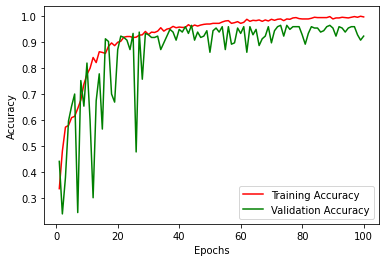

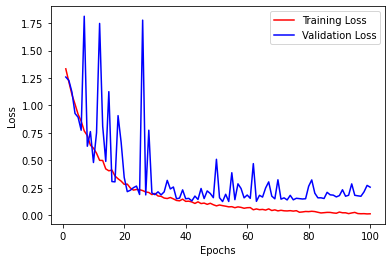

7/7 [==============================] - 0s 5ms/step - loss: 0.1427 - accuracy: 0.9637
Loss :  0.14268462359905243
Accuracy :  0.9637305736541748


In [ ]:
acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, color='red', label='Training Accuracy')
plt.plot(epochs, val_acc, color='green', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss = history.history['loss']
epochs = range(1, len(loss) + 1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, color='red', label='Training Loss')
plt.plot(epochs, val_loss, color='blue', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

classifier = tf.keras.models.load_model('/content/drive/MyDrive/Colab_Dataset/Brain Cancer/v2/dwt_normal.h5')
evaluation = classifier.evaluate(X_test, Y_test)
print('Loss : ', evaluation[0])
print('Accuracy : ', evaluation[1])

In [ ]:
# Convert Keras model to TF Lite format.
model = keras.models.load_model('/content/drive/MyDrive/Colab_Dataset/Brain Cancer/v2/dwt_normal.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in MBs.
float_model_size = len(tflite_float_model) / (1024*1024)

#Save the TFLite Model
with open("/content/drive/MyDrive/Colab_Dataset/Brain Cancer/v2/dwt_tflite.tflite", "wb") as f:
  f.write(tflite_float_model)
print(f"\n\nWrote TFLite model of {len(tflite_float_model)/(1024*1024)} mb.")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpq3av692y/assets


Wrote TFLite model of 3.0002822875976562 mb.


In [ ]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / (1024*1024)
print('Quantized model size = %f mb,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

#Save this Quantized TFLite Model
with open("/content/drive/MyDrive/Colab_Dataset/Brain Cancer/v2/dwt_quantized_TFLite.tflite", "wb") as f:
  f.write(tflite_quantized_model)
print("Wrote %sTFLite model of %f mb." %
      ("optimized " if tflite_quantized_model else "", len(tflite_quantized_model)/(1024*1024)))

INFO:tensorflow:Assets written to: /tmp/tmpe17h7mei/assets


INFO:tensorflow:Assets written to: /tmp/tmpe17h7mei/assets


Quantized model size = 0.756500 mb,
which is about 25% of the float model size.
Wrote optimized TFLite model of 0.756500 mb.


In [ ]:
from tensorflow import keras

#Read the model in
tflite_model = '/content/drive/MyDrive/Colab_Dataset/Brain Cancer/v2/dwt_tflite.tflite'
tflite_model_quantized = '/content/drive/MyDrive/Colab_Dataset/Brain Cancer/v2/dwt_quantized_TFLite.tflite'

# Initialize TFLite interpreter using the model.
# Load TFLite model and allocate tensors.

#normal
interpreter = tf.lite.Interpreter(model_path=tflite_model)
interpreter.allocate_tensors()
#quantized
interpreter_q = tf.lite.Interpreter(model_path=tflite_model_quantized)
interpreter_q.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_details_q = interpreter_q.get_input_details()
output_details_q = interpreter_q.get_output_details()
n = 0  #count for accuracy
q = 0
normal = []
quantized = []
# Test model on input data.
for i in range(1, len(X_test)):
  test_image = np.expand_dims(X_test[i], axis=0).astype(np.float32)
  interpreter.set_tensor(input_details[0]['index'], test_image)
  interpreter_q.set_tensor(input_details_q[0]['index'], test_image)
  interpreter.invoke()
  interpreter_q.invoke()

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  output_data = interpreter.get_tensor(output_details[0]['index'])
  output_data_q = interpreter_q.get_tensor(output_details_q[0]['index'])

  if np.argmax(output_data)==np.argmax(Y_test[i]):
    n+=1
  else:
    normal.append(i)

  if np.argmax(output_data_q)==np.argmax(Y_test[i]):
    q+=1
  else:
    quantized.append(i)
print('\n\nAccuracy of normal model= ', n/len(X_test))
print('\n\nAccuracy of quantized model= ', q/len(X_test))



Accuracy of normal model=  0.9637305699481865


Accuracy of quantized model=  0.9585492227979274


In [ ]:
print('Wrongly classified images of normal model :', normal)
print('Wrongly classified images of quantized model :', quantized)

Wrongly classified images of normal model : [24, 32, 75, 94, 95, 139]
Wrongly classified images of quantized model : [24, 32, 46, 75, 94, 95, 139]
